<a href="https://colab.research.google.com/github/L-azhar/workshop-test/blob/main/JAXProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import scipy.io
#import scanpy as sc

#atrix = scipy.io.mmread('/content/matrix.mtx')

#print(matrix.shape)
#print(matrix)

In [ ]:
import pandas as pd
import scipy.sparse as sp
!pip install scanpy
import scanpy as sc
import matplotlib.pyplot as plt

data_dir = '/content/'

adata = sc.read_10x_mtx(
    data_dir,
    var_names='gene_symbols',  # Uses the symbols (e.g., SLC7A1) as the index
    make_unique=True,          # Ensures duplicate gene names are handled
    cache=True
)

print(adata)

#QC
adata.var['mt'] = adata.var_names.str.startswith('MT-')     #looks for mitochondrial genes in humans
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)    #calculates the QC metrics and adds 3 columns
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)    #makes the violin plot to visualize the cutoff threshold

#filter through
print(f"Cells before filtering: {adata.n_obs}")

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=5500)
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

print(f"Cells after filtering: {adata.n_obs}")
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
#filter low expression genes
sc.pp.filter_genes(adata, min_cells=3)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 118.8 MB/s eta 0:00:00


BadGzipFile: Not a gzipped file (b'\x07B')

In [ ]:
#normalization stage
#total count normalization
sc.pp.normalize_total(adata, target_sum=1e4)

#transformation via log
sc.pp.log1p(adata)

#highly variable gene identification
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

#raw data variable assignment prior to scaling
adata.raw = adata

#remove unwanted source of variation/clear the "noise" from the data that can be caused by total count or mitochondrial precent
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

#scale the data// mean = 0, variance = 1 [gets rid of high expressed genes]
sc.pp.scale(adata, max_value=10)

print("Normalization and Scaling complete.")

# This shows the mean vs variance of all genes after normalization
sc.pl.highly_variable_genes(adata)

In [ ]:
#highly variable gene detection

# 'n_top_genes' determines how many genes to keep for dimensionality reduction (standard is 2000)
# 'flavor' can be 'seurat', 'cell_ranger', or 'seurat_v3' (seurat_v3 requires raw counts)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor='seurat'
)

#relationship between mean expression and variance (dispersion)
sc.pl.highly_variable_genes(adata)

#inspection of data
print(f"Number of highly variable genes: {adata.var['highly_variable'].sum()}")

#top 5 most variable genes
top_hvg = adata.var[adata.var['highly_variable']].sort_values('dispersions_norm', ascending=False).head(5)
print("\nTop 5 Highly Variable Genes:")
print(top_hvg.index.tolist())


In [ ]:
#Dimensionality reduction
!pip3 install igraph
!pip3 install leidenalg

#PCA collapses the 2000 HVGs into 50 main 'directions' of variation.
sc.tl.pca(adata, svd_solver='arpack')

#PCA variance
sc.pl.pca_variance_ratio(adata, log=True)

#neighborhood graph: observes what cells are similar to each other in the graph
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=30)

#run UMAP
sc.tl.umap(adata)

#visualize and conduct initial cluster
#leiden detects communities
sc.tl.leiden(adata, resolution=0.5)

sc.pl.umap(adata, color=['leiden', 'SLC7A1'],
           title=['Cell Clusters', 'SLC7A1 Expression'],
           frameon=False)

print("Dimensionality Reduction and Initial Clustering complete.")

In [ ]:
#clustering

sc.pp.neighbors(adata,n_neighbors=10, n_pcs=30)

#higher resolution = more clusters
sc.tl.leiden(adata, resolution=0.5, key_added='clusters')

# helps quantify the connectivity between clusters, which is useful
# for seeing how cells transition through the cell cycle.
sc.tl.paga(adata, groups='clusters')
sc.pl.paga(adata, show=False)
sc.tl.umap(adata, init_pos='paga')

#visualization
sc.pl.umap(adata, color=['clusters'],
           title='Leiden Clustering Groups',
           palette='Set2',
           frameon=False,
           )

#marker gene identification
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False,)

#check for Gene SLC7A1
sc.pl.violin(adata, ['SLC7A1'], groupby='clusters')

In [ ]:
import numpy as np

# Get unique cluster names
cluster_names = adata.obs['clusters'].cat.categories.tolist()
print(f"Identified clusters: {cluster_names}")

# Get top marker genes for each cluster
print("\nTop 5 Marker Genes for Each Cluster:")
for cluster in cluster_names:
    # Get the names of the top 5 genes for the current cluster
    top_genes = adata.uns['rank_genes_groups']['names'][cluster][:5]
    print(f"Cluster {cluster}: {', '.join(top_genes)}")

## Part 1 Completed - Trial with patient 10
### Gather data from 11 sampled patients for analysis
* Figure out a way to combine the files so that it can be read all at the same time
* should need to use concat for this


In [ ]:
!pip install scanpy
!pip install anndata
import scanpy as sc
import anndata as ad
import pandas as pd

# --- First set (Patient 10) ---
#load the data in and transpose cells x genes
adata10 = sc.read_mtx('matrix.mtx.gz').T

# Load barcodes and assign to obs_names
barcodes10_df = pd.read_csv('barcodes.tsv.gz', header=None, sep='\t')
adata10.obs_names = barcodes10_df[0].values

# Load features and assign to var_names, and potentially a column in .var
features10_df = pd.read_csv('features.tsv.gz', header=None, sep='\t')
adata10.var_names = features10_df[1].values # Set gene symbols as var_names
# Add gene IDs as a column to adata10.var
adata10.var['gene_ids'] = features10_df[0].values

adata10.var_names_make_unique()

# --- Second set (Patient 11) ---
adata11 = sc.read_mtx('matrix11.mtx.gz').T
barcodes11_df = pd.read_csv('barcodes11.tsv.gz', header=None, sep='\t') # Corrected filename
adata11.obs_names = barcodes11_df[0].values # Corrected target to adata11

# Load features and assign to var_names, and potentially a column in .var for adata11
features11_df = pd.read_csv('features11.tsv.gz', header=None, sep='\t') # Corrected filename
adata11.var_names = features11_df[1].values # Corrected target to adata11
# Add gene IDs as a column to adata11.var
adata11.var['gene_ids'] = features11_df[0].values # Corrected target to adata11

adata11.var_names_make_unique()

# --- Third set (Patient 16) ---
adata11 = sc.read_mtx('matrix16.mtx.gz').T
barcodes11_df = pd.read_csv('barcodes16.tsv.gz', header=None, sep='\t') # Corrected filename
adata11.obs_names = barcodes11_df[0].values # Corrected target to adata11

# Load features and assign to var_names, and potentially a column in .var for adata11
features11_df = pd.read_csv('features11.tsv.gz', header=None, sep='\t') # Corrected filename
adata11.var_names = features11_df[1].values # Corrected target to adata11
# Add gene IDs as a column to adata11.var
adata11.var['gene_ids'] = features11_df[0].values # Corrected target to adata11

adata11.var_names_make_unique()

# --- Concatenation ---
#concat - label='batch' creates a column in adata.obs to track the source
# index_unique='_' prevents duplicate cell names by adding a suffix
adata = ad.concat(
    [adata10,adata11],
    label = "batch",
    keys = ["Patient 10", "Patient 11"],
    index_unique="_",
    join="outer"
)
# Convert to Compressed Sparse Row (CSR) format for faster math/plotting
adata.X = adata.X.tocsr()

print("Merging of data completed.")
print(adata)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 91.5 MB/s eta 0:00:00
Merging of data completed.
AnnData object with n_obs × n_vars = 30925 × 32864
    obs: 'batch'


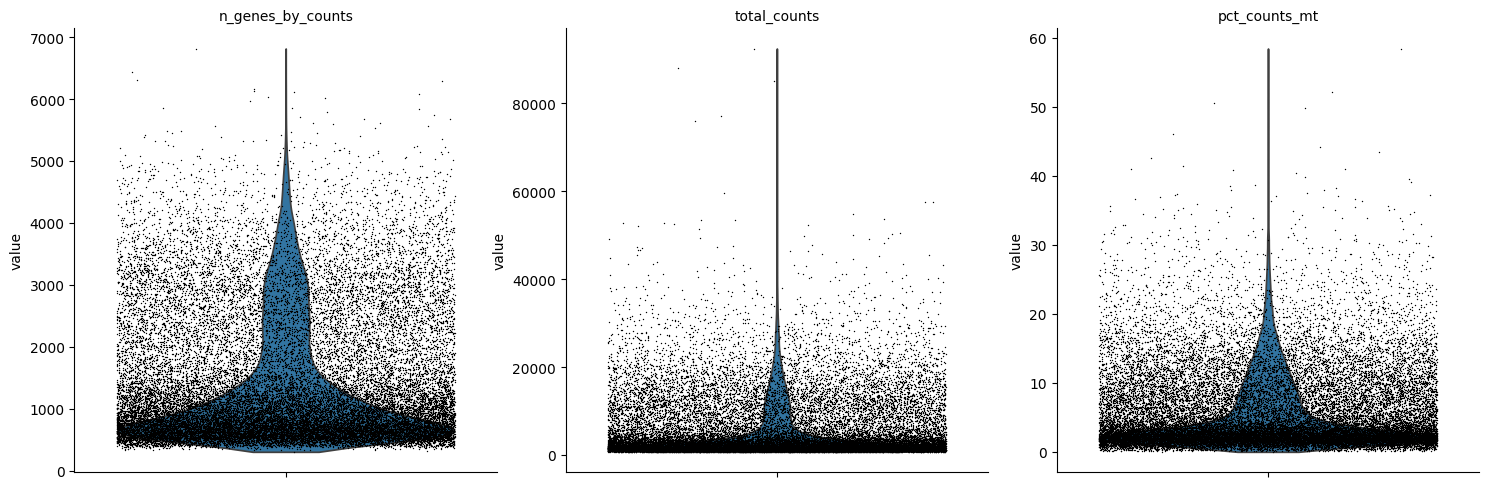

Cells before filtering: 30925
Cells after filtering: 19535


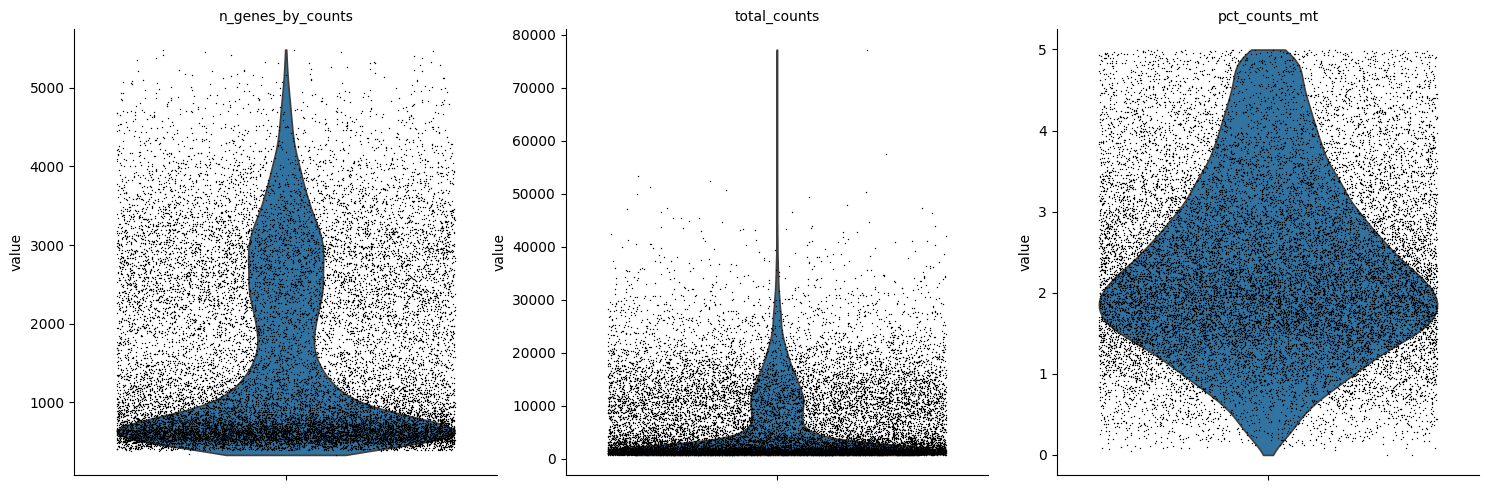

In [ ]:
#QC
adata.var['mt'] = adata.var_names.str.startswith('MT-')     #looks for mitochondrial genes in humans
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)    #calculates the QC metrics and adds 3 columns
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)    #makes the violin plot to visualize the cutoff threshold

#filter through
print(f"Cells before filtering: {adata.n_obs}")

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=5500)
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

print(f"Cells after filtering: {adata.n_obs}")
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
#filter low expression genes
sc.pp.filter_genes(adata, min_cells=3)


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:666: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:666: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


Normalization and Scaling complete.


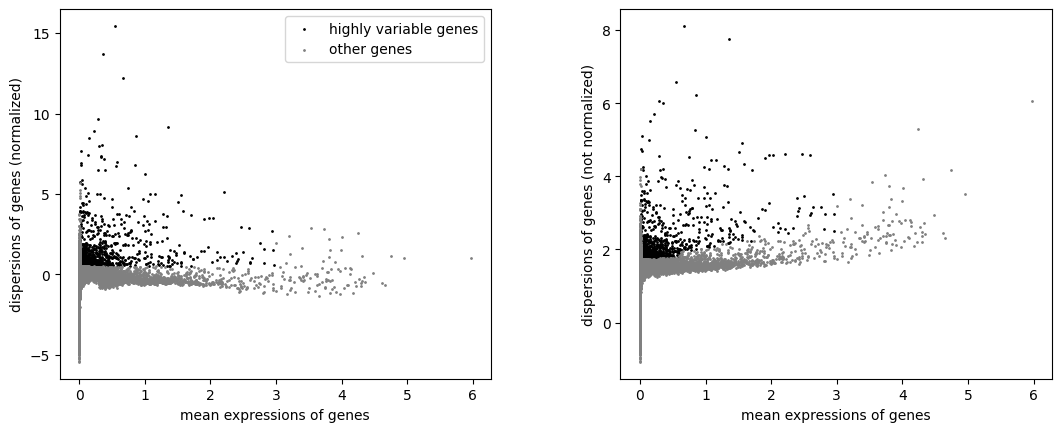

In [ ]:
#normalization stage
#total count normalization
sc.pp.normalize_total(adata, target_sum=1e4)

#transformation via log
sc.pp.log1p(adata)

#highly variable gene identification
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

#raw data variable assignment prior to scaling
adata.raw = adata

#remove unwanted source of variation/clear the "noise" from the data that can be caused by total count or mitochondrial precent
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

#scale the data// mean = 0, variance = 1 [gets rid of high expressed genes]
sc.pp.scale(adata, max_value=10)

print("Normalization and Scaling complete.")

# This shows the mean vs variance of all genes after normalization
sc.pl.highly_variable_genes(adata)

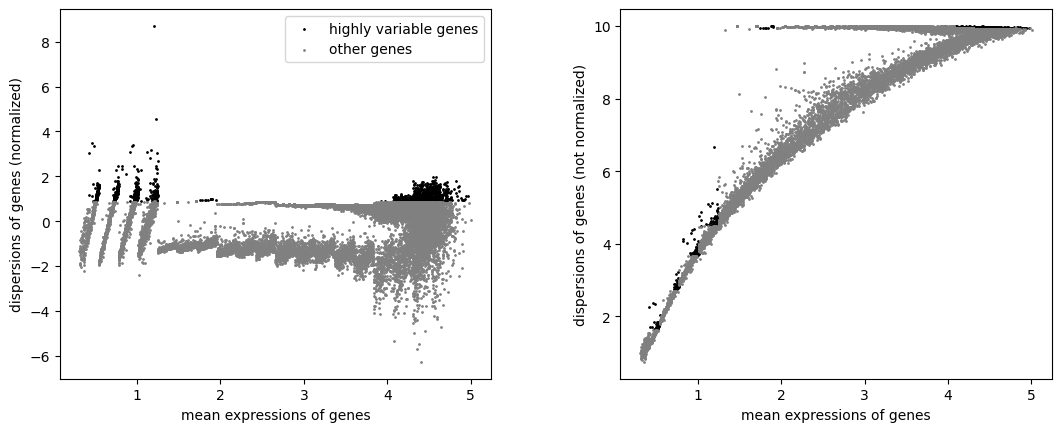

Number of highly variable genes: 2000

Top 5 Highly Variable Genes:
['AL118516.1', 'TM2D3', 'FTH1', 'MYL9', 'CLU']


In [ ]:
#highly variable gene detection

# 'n_top_genes' determines how many genes to keep for dimensionality reduction (standard is 2000)
# 'flavor' can be 'seurat', 'cell_ranger', or 'seurat_v3' (seurat_v3 requires raw counts)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor='seurat'
)

#relationship between mean expression and variance (dispersion)
sc.pl.highly_variable_genes(adata)

#inspection of data
print(f"Number of highly variable genes: {adata.var['highly_variable'].sum()}")

#top 5 most variable genes
top_hvg = adata.var[adata.var['highly_variable']].sort_values('dispersions_norm', ascending=False).head(5)
print("\nTop 5 Highly Variable Genes:")
print(top_hvg.index.tolist())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.1 MB/s eta 0:00:00


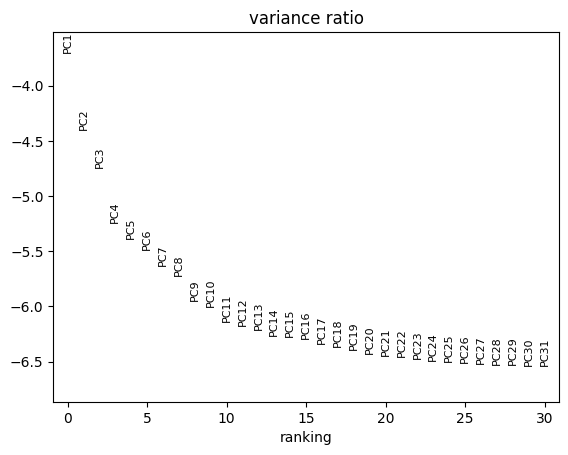

/tmp/ipython-input-1332908479.py:19: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


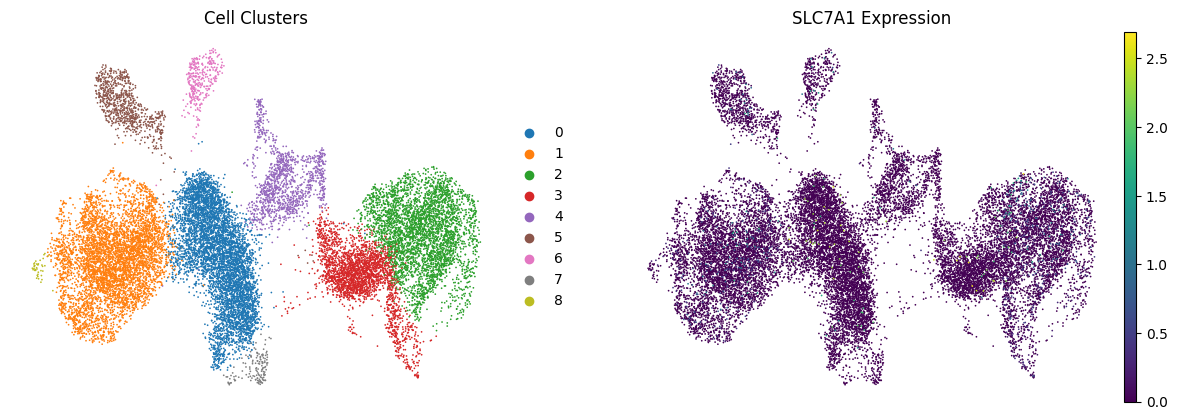

Dimensionality Reduction and Initial Clustering complete.


In [ ]:
#Dimensionality reduction
!pip3 install igraph
!pip3 install leidenalg

#PCA collapses the 2000 HVGs into 50 main 'directions' of variation.
sc.tl.pca(adata, svd_solver='arpack')

#PCA variance
sc.pl.pca_variance_ratio(adata, log=True)

#neighborhood graph: observes what cells are similar to each other in the graph
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=30)

#run UMAP
sc.tl.umap(adata)

#visualize and conduct initial cluster
#leiden detects communities
sc.tl.leiden(adata, resolution=0.5)

sc.pl.umap(adata, color=['leiden', 'SLC7A1'],
           title=['Cell Clusters', 'SLC7A1 Expression'],
           frameon=False)

print("Dimensionality Reduction and Initial Clustering complete.")

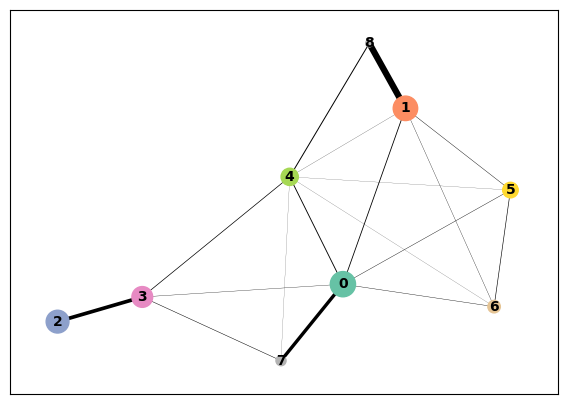

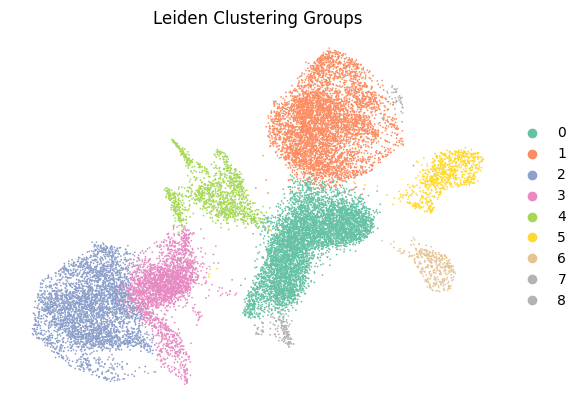

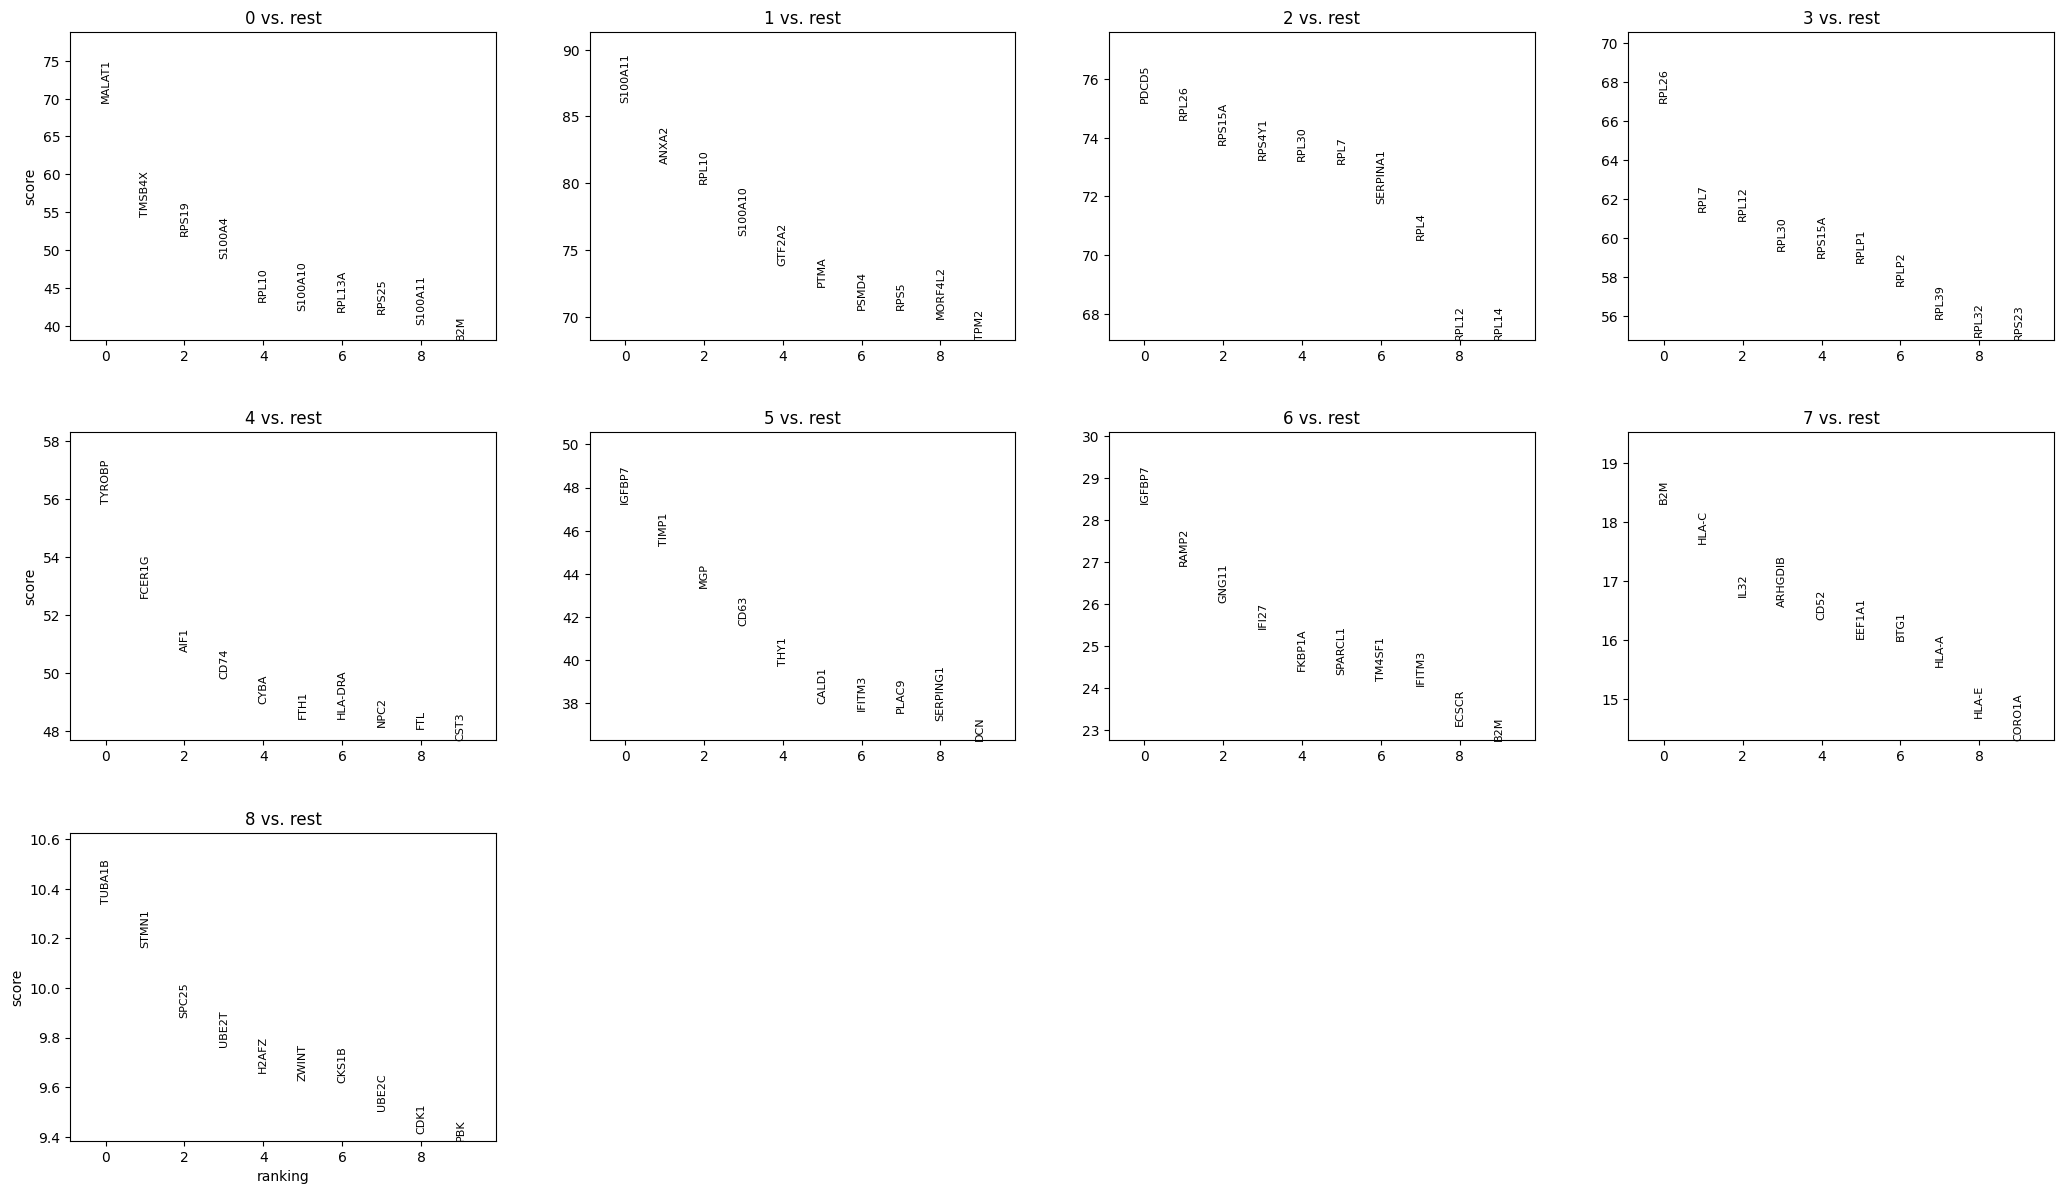

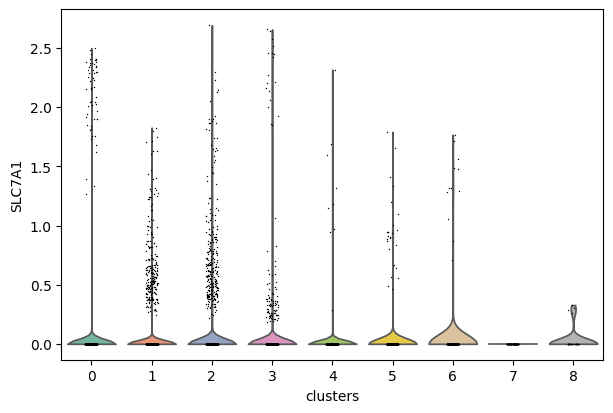

In [ ]:
#clustering

sc.pp.neighbors(adata,n_neighbors=10, n_pcs=30)

#higher resolution = more clusters
sc.tl.leiden(adata, resolution=0.5, key_added='clusters')

# helps quantify the connectivity between clusters, which is useful
# for seeing how cells transition through the cell cycle.
sc.tl.paga(adata, groups='clusters')
sc.pl.paga(adata, show=False)
sc.tl.umap(adata, init_pos='paga')

#visualization
sc.pl.umap(adata, color=['clusters'],
           title='Leiden Clustering Groups',
           palette='Set2',
           frameon=False,
           )

#marker gene identification
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False,)

#check for Gene SLC7A1
sc.pl.violin(adata, ['SLC7A1'], groupby='clusters')

In [ ]:
from __future__ import annotations

import zipfile

import pooch
import scanpy as sc


sc.logging.print_header()

p_zip = pooch.retrieve(
    "https://www.dropbox.com/s/3dby3bjsaf5arrw/cell_cycle_vignette_files.zip?dl=1",
    known_hash="sha256:6557fe2a2761d1550d41edf61b26c6d5ec9b42b4933d56c3161164a595f145ab",
    path="../data",

# filter out cell cycle genes that are not present in dataset
with zipfile.ZipFile(p_zip, "r") as f_zip:
    f_csv = zipfile.Path(f_zip, "nestorawa_forcellcycle_expressionMatrix.txt").open()
    adata = sc.read_csv(f_csv, delimiter="\t").T
    cell_cycle_genes = zipfile.Path(f_zip, "regev_lab_cell_cycle_genes.txt").read_text().splitlines()

# Defining genes associated to S phase and genes associated to G2M phase
s_genes = [x for x in cell_cycle_genes[:43] if x in adata.var_names]
g2m_genes = [x for x in cell_cycle_genes[43:] if x in adata.var_names]
cell_cycle_genes = [*s_genes, *g2m_genes]

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)

#sorting into S phase, G1 phase, or G2M phase
sc.pp.log1p(adata)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

#Validate cell cycle scoring and visualize data
adata_cc_genes = adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color="phase")